<a href="https://colab.research.google.com/github/omerhac/flower_calssification/blob/master/flower_classificaiton_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
import math, os, sys, re
import numpy as np
import tensorflow as tf
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
print("tf version: " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

tf version: 2.2.0-rc2


# Hardware detection


In [2]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)


Running on CPU
Number of accelerators:  1


## Utilities

In [0]:
def get_numpy_batch(dataset, n_samples):
  """get numpy array of n samples"""
  dataset = dataset.shuffle(buffer_size=10)
  batched = dataset.batch(n_samples)
  for images, labels in batched:
    return images.numpy(), labels.numpy()

def show_n_samples(dataset, n):
  """prints n images and labels"""
  plt.figure(figsize = (2 * n, 2 *n))

  rows = math.ceil(n / 3)

  batch_images, batch_labels = get_numpy_batch(dataset, n)

  for i, image in enumerate(batch_images):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[batch_labels[i]])
  
  plt.show()

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def count_dataset_items(dataset):
  # counts items iterativly in the data set. requaiers some time...
  count = 0
  for obj in dataset:
    count += 1
  
  return count

def display_training_curves(hist, with_val=False):
  """display learning curves for keras history dict, args: history dict, with val --> boolean with/without val"""
  plt.figure(figsize=(18,6))

  # accuracy plots
  plt.subplot(1,2,1)
  plt.plot(hist['accuracy'])
  
  if with_val:
    plt.plot(hist['val_accuracy'])
    plt.legend(['Train', 'Validation'])
  
  else:
    plt.legend(['Train'])
  
  plt.title('Model accuracy')
  plt.xlabel('EPOCH')
  plt.ylabel('Accuracy')

  # loss plots
  plt.subplot(1,2,2)
  plt.plot(hist['loss'])

  if with_val:
    plt.plot(hist['val_loss'])
    plt.legend(['Train loss', 'Val loss'])
  
  else:
    plt.legend(['Train loss'])
  
  plt.title('Model loss')
  plt.xlabel('EPOCH')
  plt.ylabel('Loss')
  plt.show()

def display_model_predictions(model, dataset):
  """Displays 9 images and their predictions"""

  batch_images, batch_labels = get_numpy_batch(dataset, 9)
  predictions = model.predict(batch_images) # predict images labels
  
  plt.figure(figsize=(18,18))

  for i, image in enumerate(batch_images):
    # def plot
    plt.subplot(3,3,i + 1)
    plt.imshow(image)

    # write prediction as titles
    pred =np.argmax(predictions[i])
    if pred == batch_labels[i]:
      plt.title(CLASSES[pred], fontdict={'color':'g'})

    else:
      plt.title(CLASSES[pred] + " WRONG --> " + CLASSES[batch_labels[i]], fontdict={'color': 'r'})
    
  plt.show()



# Loading images

In [0]:
# read tfrecords from gcs
def read_tfrecord(example):
  """Parses one tf record to image, class, one_hot_class"""
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "class": tf.io.FixedLenFeature([], tf.int64),
  }

  example = tf.io.parse_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
  label = tf.cast(example['class'], tf.int32)
  return image, label

def load_tfrecord_dataset(dataset_filenames):
  """Loads a TFRecord dataset. args: dataset_filnames --> list of strings of files paths"""

  # allows for no order parallel reading
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(dataset_filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset


In [0]:
# getting image paths
IMAGE_SIZE = [512, 512]

GCS_PATH = "gs://kds-b2e6cdbc4af76dcf0363776c09c12fe46872cab211d1de9f60ec7aec" # GCS path for competition data

# dict for paths to different image sizes
GCS_PATH_SELECT = { # available image sizes
    192: GCS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_PATH + '/tfrecords-jpeg-512x512'
}

# get full path with image size and split to train / val / test
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

# get length of datasets
TRAINING_LENGTH = count_data_items(TRAINING_FILENAMES)
VALIDATION_LENGTH = count_data_items(VALIDATION_FILENAMES)
TEST_LENGTH = count_data_items(TEST_FILENAMES)

In [0]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

In [0]:
whole_dataset = load_tfrecord_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES + TEST_FILENAMES)
training_dataset = load_tfrecord_dataset(TRAINING_FILENAMES)
validation_dataset = load_tfrecord_dataset(VALIDATION_FILENAMES)
#test_dataset = load_tfrecord_dataset(TEST_FILENAMES) # have to create a function to load test items from tfrecord

# batch datset
BATCH_SIZE = 128
STEPS_PER_EPOCH = TRAINING_LENGTH // BATCH_SIZE
batched_whole_dataset = whole_dataset.batch(BATCH_SIZE)
batched_training_dataset = training_dataset.batch(BATCH_SIZE)
batched_validation_dataset = validation_dataset.batch(BATCH_SIZE)

# Simple transfer learning model

In [0]:
def get_pretrained_model():
  # get xception pretrained model
  xception = keras.applications.Xception(include_top=False, input_shape=[*IMAGE_SIZE,3])
  xception.trainable = False

  # define model
  simple_model = keras.models.Sequential([
    xception,
    keras.layers.GlobalAveragePooling2D(),
    #keras.layers.Flatten(),
    keras.layers.Dense(len(CLASSES), activation='softmax')
  ])

  simple_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return simple_model

In [11]:
with strategy.scope():
  model = get_pretrained_model()
  model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 21,074,576
Trainable params: 213,096
Non-trainable params: 20,861,480
_________________________________________________________________


In [0]:
hist = model.fit(batched_training_dataset, epochs=10, validation_data=validation_dataset.batch(BATCH_SIZE))

Epoch 1/10
100/100 [==============================] - 34s 343ms/step - accuracy: 0.3129 - loss: 3.1824 - val_accuracy: 0.5089 - val_loss: 2.3958
Epoch 2/10
100/100 [==============================] - 20s 199ms/step - accuracy: 0.5925 - loss: 1.9843 - val_accuracy: 0.6463 - val_loss: 1.7322
Epoch 3/10
100/100 [==============================] - 20s 198ms/step - accuracy: 0.7038 - loss: 1.4821 - val_accuracy: 0.7204 - val_loss: 1.4056
Epoch 4/10
100/100 [==============================] - 20s 202ms/step - accuracy: 0.7603 - loss: 1.2069 - val_accuracy: 0.7511 - val_loss: 1.2149
Epoch 5/10
100/100 [==============================] - 20s 198ms/step - accuracy: 0.7942 - loss: 1.0312 - val_accuracy: 0.7815 - val_loss: 1.0884
Epoch 6/10
100/100 [==============================] - 20s 203ms/step - accuracy: 0.8200 - loss: 0.9043 - val_accuracy: 0.7926 - val_loss: 0.9993
Epoch 7/10
100/100 [==============================] - 20s 204ms/step - accuracy: 0.8387 - loss: 0.8104 - val_accuracy: 0.8047 - va

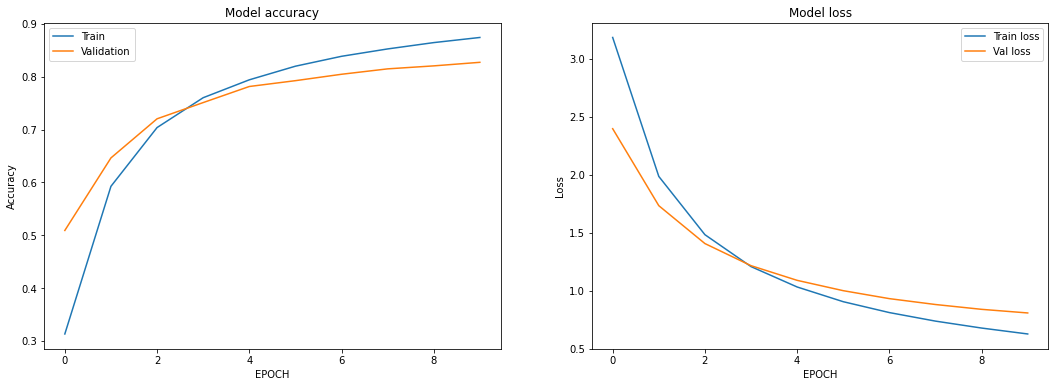

In [0]:
display_training_curves(hist.history, with_val=True)

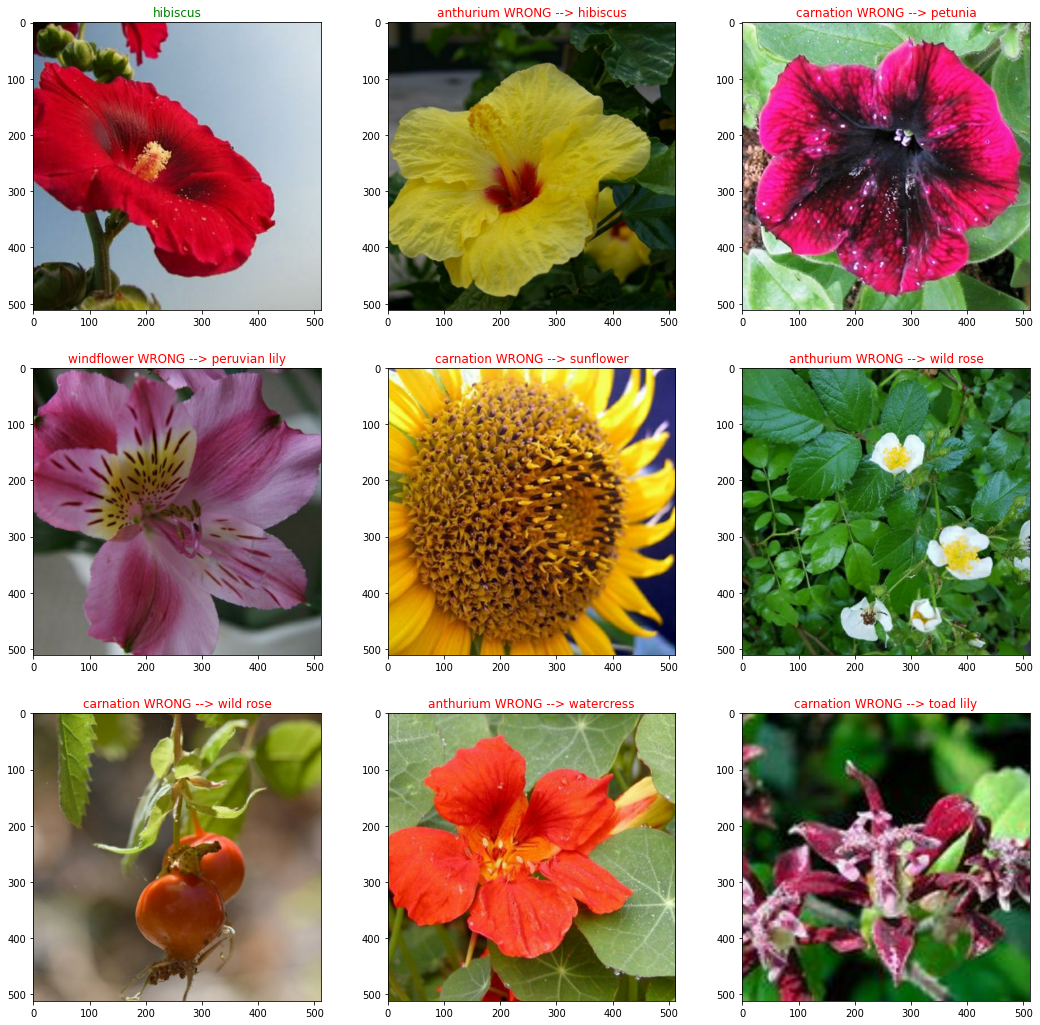

In [22]:
display_model_predictions(model, validation_dataset)